In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from energydisaggregation.models.stat_model import Stats, preprocess, split_year 

## Data processsing

### Collect source variables (Date, Région, Temperature, ER, ET, GR, GT)

In [46]:
# Import data
df_src = pd.read_csv("EnergyDisaggregation/energydisaggregation/data_storage/df_process.csv", sep=",")
# df_src.info()
df_src.columns

Index(['Date - Heure', 'Région', 'consommation brute électricité (mw) - rte',
       'température (°c)', 'nebulosité totale', 'vitesse du vent moyen 10 mn',
       'humidité', 'vitesse du vent en km/h', 'température ressentie',
       'saison', 'week_day', 'month', 'hour', 'is_holiday', 'is_bank_holiday',
       'day_of_year', 'years', 'regions', 'temperature_seuil', 'saturation',
       'diff_seuil', 'température ressentie.1', 'température (°c)_mean_48',
       'température (°c)_std_48', 'température (°c)_max_48',
       'température (°c)_min_48', 'nebulosité totale_mean_3',
       'nebulosité totale_std_3', 'month_sin', 'month_cos', 'week_day_sin',
       'week_day_cos', 'hour_sin', 'hour_cos',
       'consommation brute électricité (mw) - rte_lag_1',
       'consommation brute électricité (mw) - rte_lag_2',
       'consommation brute électricité (mw) - rte_lag_3',
       'consommation brute électricité (mw) - rte_lag_4',
       'consommation brute électricité (mw) - rte_lag_5',
    

In [59]:
df_X = df_src.copy()

vars_selected = ['Date - Heure', 'température (°c)', 'Région', 'saison', 'week_day', 'is_holiday', 'is_bank_holiday', 'consommation brute électricité (mw) - rte']
df_X = df_X[vars_selected]


# We truncate "Date - Heure" so that we only keep the Date
def truncate(s,start=0,end=10):
    return s[start:end]

var = "Date - Heure"
res_map = map(truncate,df_src[var])
date_truncated = pd.Series(np.array(list(res_map)))
date_truncated = pd.to_datetime(date_truncated,format='%Y-%m-%d')
df_X['Date - Heure'] = date_truncated

In [60]:
vars_X = ['Date', 'Temp', 'Région', 'saison', 'week_day', 'is_holiday', 'is_bank_holiday', 'ce']
renamed_vars = dict(zip(vars_selected,vars_X))
renamed_vars

{'Date - Heure': 'Date',
 'température (°c)': 'Temp',
 'Région': 'Région',
 'saison': 'saison',
 'week_day': 'week_day',
 'is_holiday': 'is_holiday',
 'is_bank_holiday': 'is_bank_holiday',
 'consommation brute électricité (mw) - rte': 'ce'}

In [61]:
df_X = df_X.rename(columns=renamed_vars)
df_X

,Date,Temp,Région,saison,week_day,is_holiday,is_bank_holiday,ce
0,2013-01-01,9.375000,Auvergne-Rhône-Alpes,3,1,True,True,8173.0
1,2013-01-01,2.675000,Bourgogne-Franche-Comté,3,1,True,True,2357.0
2,2013-01-01,9.475000,Bretagne,3,1,True,True,3050.0
3,2013-01-01,8.200000,Centre-Val de Loire,3,1,True,True,2476.0
4,2013-01-01,5.075000,Grand Est,3,1,True,True,4943.0
...,...,...,...,...,...,...,...,...
736123,2019-12-31,8.133333,Nouvelle-Aquitaine,3,1,True,False,12110.0
736124,2019-12-31,5.000000,Occitanie,3,1,True,False,10984.0
736125,2019-12-31,7.525000,Pays de la Loire,3,1,True,False,8133.0
736126,2019-12-31,4.450000,Provence-Alpes-Côte d'Azur,3,1,True,False,12127.0


In [66]:
df_X = df_X.groupby(['Date','Région']).mean()
df_X

Temp  saison  week_day  is_holiday  \
Date       Région                                                               
2013-01-01 Auvergne-Rhône-Alpes        6.137500     3.0       1.0         1.0   
           Bourgogne-Franche-Comté     5.512500     3.0       1.0         1.0   
           Bretagne                    8.370833     3.0       1.0         1.0   
           Centre-Val de Loire         7.590625     3.0       1.0         1.0   
           Grand Est                   6.761458     3.0       1.0         1.0   
...                                         ...     ...       ...         ...   
2019-12-31 Nouvelle-Aquitaine          5.902083     3.0       1.0         1.0   
           Occitanie                   6.320833     3.0       1.0         1.0   
           Pays de la Loire            5.019792     3.0       1.0         1.0   
           Provence-Alpes-Côte d'Azur  7.189583     3.0       1.0         1.0   
           Île-de-France               0.692708     3.0       1.0         1.0   

                                       is_bank_holiday            ce  
Date       Région                                                     
2013-01-01 Auvergne-Rhône-Alpes                    1.0  14806.625000  
           Bourgogne-Franche-Comté                 1.0   4602.791667  
           Bretagne                                1.0   5082.458333  
           Centre-Val de Loire                     1.0   4300.750000  
           Grand Est                               1.0   9138.250000  
...                                                ...           ...  
2019-12-31 Nouvelle-Aquitaine                      0.0  12763.833333  
           Occitanie                               0.0  10639.666667  
           Pays de la Loire                        0.0   8230.041667  
           Provence-Alpes-Côte d'Azur              0.0  11406.666667  
           Île-de-France                           0.0  21026.000000  

[30672 rows x 6 columns]

In [75]:
df_X = df_X.reset_index()
df_X

,Date,Région,Temp,saison,week_day,is_holiday,is_bank_holiday,ce
0,2013-01-01,Auvergne-Rhône-Alpes,6.137500,3.0,1.0,1.0,1.0,14806.625000
1,2013-01-01,Bourgogne-Franche-Comté,5.512500,3.0,1.0,1.0,1.0,4602.791667
2,2013-01-01,Bretagne,8.370833,3.0,1.0,1.0,1.0,5082.458333
3,2013-01-01,Centre-Val de Loire,7.590625,3.0,1.0,1.0,1.0,4300.750000
4,2013-01-01,Grand Est,6.761458,3.0,1.0,1.0,1.0,9138.250000
...,...,...,...,...,...,...,...,...
30667,2019-12-31,Nouvelle-Aquitaine,5.902083,3.0,1.0,1.0,0.0,12763.833333
30668,2019-12-31,Occitanie,6.320833,3.0,1.0,1.0,0.0,10639.666667
30669,2019-12-31,Pays de la Loire,5.019792,3.0,1.0,1.0,0.0,8230.041667
30670,2019-12-31,Provence-Alpes-Côte d'Azur,7.189583,3.0,1.0,1.0,0.0,11406.666667


### Emissions weigts per region

In [67]:
df_emissions = pd.read_csv("../Data/emissions_2020_2021_reg.csv", sep=";")
df_emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   years                 24 non-null     int64 
 1   Région                24 non-null     object
 2   CO2e (kg) par hab     24 non-null     int64 
 3   Nb hab (en milliers)  24 non-null     object
 4   CO2e (kg) total       24 non-null     object
 5   Poids                 24 non-null     object
dtypes: int64(2), object(4)
memory usage: 1.3+ KB


In [68]:
# Convert the variables to numeric
vars = ['Nb hab (en milliers)','CO2e (kg) total','Poids']

for var in vars:
    df_emissions[var] = df_emissions[var].str.replace(r'[,]', '.', regex=True) # convert , into .
    df_emissions[var] = pd.to_numeric(df_emissions[var])


# Obtain the weigts for each region
carbon_weights = df_emissions.groupby(['Région']).mean()['Poids']
carbon_weights

Région
Auvergne-Rhône-Alpes          0.120715
Bourgogne-Franche-Comté       0.041468
Bretagne                      0.055237
Centre-Val de Loire           0.037048
Grand Est                     0.080020
Hauts-de-France               0.099611
Normandie                     0.050932
Nouvelle-Aquitaine            0.093203
Occitanie                     0.089981
Pays de la Loire              0.057626
Provence-Alpes-Côte d'Azur    0.084029
Île-de-France                 0.190130
Name: Poids, dtype: float64

### Total emissions per day (MtCO2 / day)

In [69]:
df_carbon_eu = pd.read_csv("../Data/carbonmonitor-eu_datas_2024-02-23.csv", sep=",")
df_carbon_eu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345402 entries, 0 to 345401
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   country    345402 non-null  object 
 1   date       345402 non-null  object 
 2   sector     345402 non-null  object 
 3   value      345402 non-null  float64
 4   timestamp  345402 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 13.2+ MB


In [70]:
df_carbon_eu['sector'].unique()

array(['Power', 'Industry', 'Ground Transport', 'Residential',
       'International Aviation', 'Domestic Aviation'], dtype=object)

In [72]:
df_carbon_fr = df_carbon_eu[df_carbon_eu['sector'] == 'Power'] # Only electricity emissions
df_carbon_fr = df_carbon_fr[df_carbon_fr['country'] == 'France'] # Only France emissions
df_carbon_fr['date'] = pd.to_datetime(df_carbon_fr['date'],format='%d/%m/%Y') # convert to datetime
df_carbon_fr = pd.DataFrame({'Date' : df_carbon_fr['date'], 'Emissions' : df_carbon_fr['value']},columns=['Date','Emissions'])
df_carbon_fr = df_carbon_fr.reset_index(drop=True)
df_carbon_fr

,Date,Emissions
0,2019-01-01,0.052318
1,2019-01-02,0.080056
2,2019-01-03,0.094601
3,2019-01-04,0.106710
4,2019-01-05,0.115383
...,...,...
1852,2024-01-27,0.053079
1853,2024-01-28,0.052237
1854,2024-01-29,0.057638
1855,2024-01-30,0.063976


### Synchronize `Date` of `df_X` and `df_carbon_fr`

In [76]:
df_X = df_X[df_X['Date'] >= "2019-01-01"]
df_X = df_X.reset_index(drop=True)
df_X

,Date,Région,Temp,saison,week_day,is_holiday,is_bank_holiday,ce
0,2019-01-01,Auvergne-Rhône-Alpes,3.832292,3.0,1.0,1.0,1.0,16616.000000
1,2019-01-01,Bourgogne-Franche-Comté,6.077083,3.0,1.0,1.0,1.0,5077.333333
2,2019-01-01,Bretagne,8.797917,3.0,1.0,1.0,1.0,5400.666667
3,2019-01-01,Centre-Val de Loire,7.047917,3.0,1.0,1.0,1.0,4940.458333
4,2019-01-01,Grand Est,5.632292,3.0,1.0,1.0,1.0,9710.583333
...,...,...,...,...,...,...,...,...
4375,2019-12-31,Nouvelle-Aquitaine,5.902083,3.0,1.0,1.0,0.0,12763.833333
4376,2019-12-31,Occitanie,6.320833,3.0,1.0,1.0,0.0,10639.666667
4377,2019-12-31,Pays de la Loire,5.019792,3.0,1.0,1.0,0.0,8230.041667
4378,2019-12-31,Provence-Alpes-Côte d'Azur,7.189583,3.0,1.0,1.0,0.0,11406.666667


In [77]:
df_carbon_fr = df_carbon_fr[df_carbon_fr['Date'] < "2020"]
df_carbon_fr = df_carbon_fr.reset_index(drop=True)
df_carbon_fr

,Date,Emissions
0,2019-01-01,0.052318
1,2019-01-02,0.080056
2,2019-01-03,0.094601
3,2019-01-04,0.106710
4,2019-01-05,0.115383
...,...,...
360,2019-12-27,0.051813
361,2019-12-28,0.054661
362,2019-12-29,0.055831
363,2019-12-30,0.061169


Now `df_X` and `df_carbon_fr` are the same length, modulo the number of regions :

In [78]:
len(df_X) / len(df_carbon_fr)

12.0

In [79]:
REGIONS = np.unique(df_emissions['Région'])
print(len(REGIONS))
print(REGIONS)

12
['Auvergne-Rhône-Alpes' 'Bourgogne-Franche-Comté' 'Bretagne'
 'Centre-Val de Loire' 'Grand Est' 'Hauts-de-France' 'Normandie'
 'Nouvelle-Aquitaine' 'Occitanie' 'Pays de la Loire'
 "Provence-Alpes-Côte d'Azur" 'Île-de-France']


### Apply the weigts to `df_carbon_fr`

In [80]:
df_y = pd.merge(df_carbon_fr, pd.DataFrame({"Région" : REGIONS, "weights" : np.array(carbon_weights)}), how="cross")
df_y['Emissions'] = df_y['Emissions'] * df_y['weights']
df_y = df_y.drop(columns='weights')
df_y

,Date,Emissions,Région
0,2019-01-01,0.006316,Auvergne-Rhône-Alpes
1,2019-01-01,0.002170,Bourgogne-Franche-Comté
2,2019-01-01,0.002890,Bretagne
3,2019-01-01,0.001938,Centre-Val de Loire
4,2019-01-01,0.004186,Grand Est
...,...,...,...
4375,2019-12-31,0.006660,Nouvelle-Aquitaine
4376,2019-12-31,0.006430,Occitanie
4377,2019-12-31,0.004118,Pays de la Loire
4378,2019-12-31,0.006005,Provence-Alpes-Côte d'Azur


In [81]:
df_processed = df_X.set_index(['Date','Région']).join(df_y.set_index(['Date','Région']),on=['Date','Région'])
df_processed = df_processed.reset_index()
df_processed

,Date,Région,Temp,saison,week_day,is_holiday,is_bank_holiday,ce,Emissions
0,2019-01-01,Auvergne-Rhône-Alpes,3.832292,3.0,1.0,1.0,1.0,16616.000000,0.006316
1,2019-01-01,Bourgogne-Franche-Comté,6.077083,3.0,1.0,1.0,1.0,5077.333333,0.002170
2,2019-01-01,Bretagne,8.797917,3.0,1.0,1.0,1.0,5400.666667,0.002890
3,2019-01-01,Centre-Val de Loire,7.047917,3.0,1.0,1.0,1.0,4940.458333,0.001938
4,2019-01-01,Grand Est,5.632292,3.0,1.0,1.0,1.0,9710.583333,0.004186
...,...,...,...,...,...,...,...,...,...
4375,2019-12-31,Nouvelle-Aquitaine,5.902083,3.0,1.0,1.0,0.0,12763.833333,0.006660
4376,2019-12-31,Occitanie,6.320833,3.0,1.0,1.0,0.0,10639.666667,0.006430
4377,2019-12-31,Pays de la Loire,5.019792,3.0,1.0,1.0,0.0,8230.041667,0.004118
4378,2019-12-31,Provence-Alpes-Côte d'Azur,7.189583,3.0,1.0,1.0,0.0,11406.666667,0.006005


## Model

In [36]:
# df_processed

### Sequential - Date

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [23]:
# Load data
data = df_processed.copy()
# Assuming the data is already preprocessed and features are appropriately encoded

# Encode categorical variables
encoder = LabelEncoder()
data['Région'] = encoder.fit_transform(data['Région'])

# Extract features from Date column
data['Year'] = pd.to_datetime(data['Date']).dt.year
data['Month'] = pd.to_datetime(data['Date']).dt.month
data['Day'] = pd.to_datetime(data['Date']).dt.day

# Drop the original Date column
data = data.drop(columns=['Date'])

# Normalize numerical features
scaler = StandardScaler()
data[['Year', 'Month', 'Day', 'Temp', 'Emissions']] = scaler.fit_transform(data[['Year', 'Month', 'Day', 'Temp', 'Emissions']])

# Split data into features and target
X = data[['Year', 'Month', 'Day', 'Région', 'Temp']]
y = data['Emissions']


Epoch 1/50

88/88 [==============================] - 2s 7ms/step - loss: 1.0866 - val_loss: 0.3487
Epoch 2/50
88/88 [==============================] - 0s 5ms/step - loss: 0.7956 - val_loss: 0.2930
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.7125 - val_loss: 0.2837
Epoch 4/50
88/88 [==============================] - 1s 7ms/step - loss: 0.6571 - val_loss: 0.3222
Epoch 5/50
88/88 [==============================] - 1s 7ms/step - loss: 0.6131 - val_loss: 0.3142
Epoch 6/50
88/88 [==============================] - 0s 3ms/step - loss: 0.5847 - val_loss: 0.3281
Epoch 7/50
88/88 [==============================] - 0s 4ms/step - loss: 0.5530 - val_loss: 0.3864
Epoch 8/50
28/28 [==============================] - 0s 4ms/step - loss: 1.3233
Test Loss: 1.3232694864273071
28/28 [==============================] - 0s 3ms/step


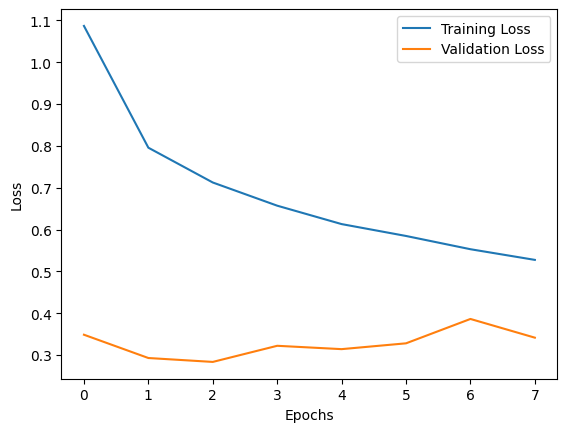

In [24]:
# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict on test data
y_pred = model.predict(X_test)

# You can inverse scale the predictions if necessary
# predictions = scaler.inverse_transform(predictions)

# Optionally, you can plot the training and validation loss to observe the training progress
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
np.linalg.norm(np.array(y_pred.ravel() - y_test))

34.04679532439799

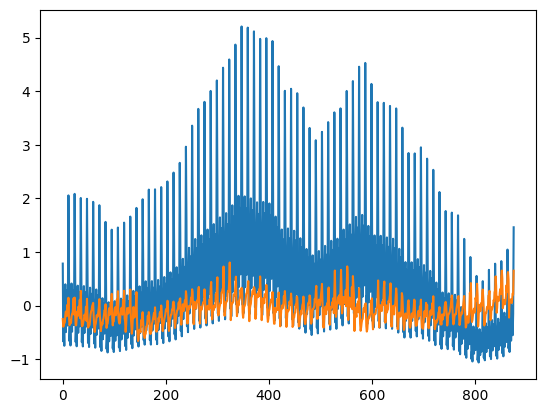

In [26]:
plt.plot(np.array(y_test))
plt.plot(y_pred.ravel())

### LSTM - Date

Epoch 1/50
88/88 [==============================] - 6s 22ms/step - loss: 0.8410 - val_loss: 0.3755
Epoch 2/50
88/88 [==============================] - 1s 9ms/step - loss: 0.5936 - val_loss: 0.4086
Epoch 3/50
88/88 [==============================] - 1s 9ms/step - loss: 0.5226 - val_loss: 0.4453
Epoch 4/50
88/88 [==============================] - 1s 9ms/step - loss: 0.5051 - val_loss: 0.4228
Epoch 5/50
88/88 [==============================] - 1s 7ms/step - loss: 0.4951 - val_loss: 0.4171
Epoch 6/50
28/28 [==============================] - 0s 5ms/step - loss: 1.4928
Test Loss: 1.4928358793258667
28/28 [==============================] - 1s 3ms/step


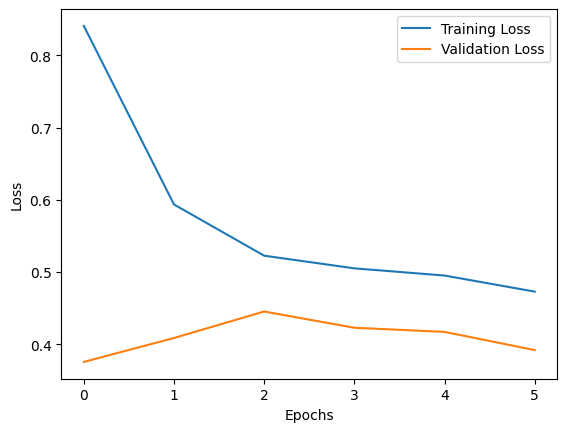

In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load data
data = df_processed.copy()
# Assuming the data is already preprocessed and features are appropriately encoded

# Encode categorical variables
encoder = LabelEncoder()
data['Région'] = encoder.fit_transform(data['Région'])

# Extract features from Date column
data['Year'] = pd.to_datetime(data['Date']).dt.year
data['Month'] = pd.to_datetime(data['Date']).dt.month
data['Day'] = pd.to_datetime(data['Date']).dt.day

# Drop the original Date column
data = data.drop(columns=['Date'])

# Normalize numerical features
scaler = StandardScaler()
data[['Year', 'Month', 'Day', 'Temp', 'Emissions']] = scaler.fit_transform(data[['Year', 'Month', 'Day', 'Temp', 'Emissions']])

# Split data into features and target
X = data[['Year', 'Month', 'Day', 'Région', 'Temp']]
y = data['Emissions']

# Reshape features for LSTM input [samples, timesteps, features]
X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict on test data
y_pred = model.predict(X_test)

# Optionally, you can inverse scale the predictions if necessary
# predictions = scaler.inverse_transform(predictions)

# Optionally, you can plot the training and validation loss to observe the training progress
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
np.linalg.norm(np.array(y_pred.ravel() - y_test))

36.16246884787553

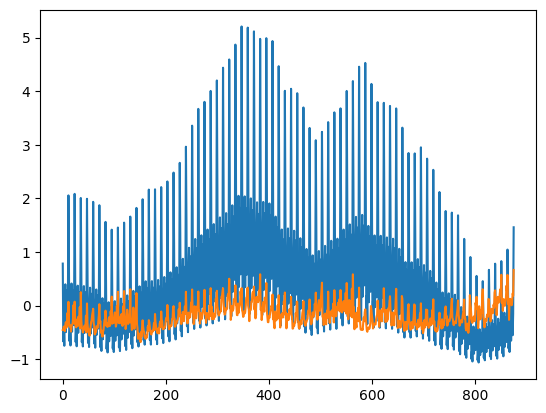

In [29]:
plt.plot(np.array(y_test))
plt.plot(y_pred.ravel())

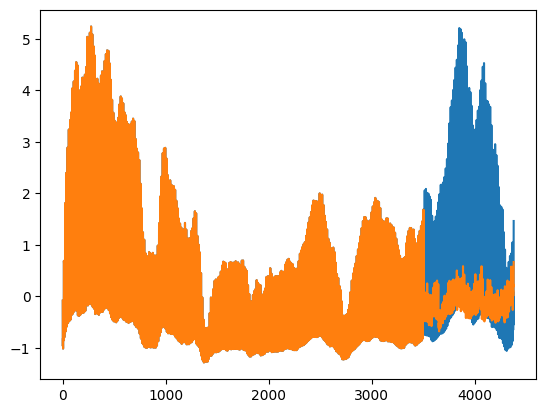

In [30]:
plt.plot(y)
plt.plot(np.concatenate((y_train.ravel(),y_pred.ravel())))
plt.show()

### LSTM - sinus cos transformation

Epoch 1/50
88/88 [==============================] - 6s 19ms/step - loss: 0.7935 - val_loss: 0.3327
Epoch 2/50
88/88 [==============================] - 1s 10ms/step - loss: 0.5403 - val_loss: 0.3099
Epoch 3/50
88/88 [==============================] - 1s 13ms/step - loss: 0.5112 - val_loss: 0.3035
Epoch 4/50
88/88 [==============================] - 1s 10ms/step - loss: 0.4924 - val_loss: 0.3055
Epoch 5/50
88/88 [==============================] - 1s 9ms/step - loss: 0.4759 - val_loss: 0.2954
Epoch 6/50
88/88 [==============================] - 1s 8ms/step - loss: 0.4465 - val_loss: 0.2807
Epoch 7/50
88/88 [==============================] - 1s 7ms/step - loss: 0.4371 - val_loss: 0.2784
Epoch 8/50
88/88 [==============================] - 1s 7ms/step - loss: 0.4333 - val_loss: 0.2599
Epoch 9/50
88/88 [==============================] - 1s 7ms/step - loss: 0.4153 - val_loss: 0.2574
Epoch 10/50
88/88 [==============================] - 1s 9ms/step - loss: 0.4109 - val_loss: 0.2451
Epoch 11/50
88/

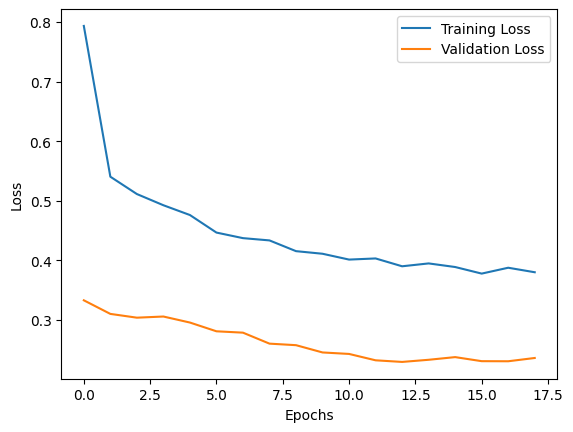

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load data
data = df_processed.copy()
# Assuming the data is already preprocessed and features are appropriately encoded

# Encode categorical variables
encoder = LabelEncoder()
data['Région'] = encoder.fit_transform(data['Région'])

# Convert Date to sinusoidal and cosinusoidal components
data['Date'] = pd.to_datetime(data['Date'])
data['Day_sin'] = np.sin(2 * np.pi * data['Date'].dt.day / 31)
data['Day_cos'] = np.cos(2 * np.pi * data['Date'].dt.day / 31)
data['Month_sin'] = np.sin(2 * np.pi * data['Date'].dt.month / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Date'].dt.month / 12)
data['Year_sin'] = np.sin(2 * np.pi * data['Date'].dt.year)
data['Year_cos'] = np.cos(2 * np.pi * data['Date'].dt.year)

# Drop the original Date column
data = data.drop(columns=['Date'])

# Normalize numerical features
scaler = StandardScaler()
var_names = ['Day_sin', 'Day_cos', 'Month_sin', 'Month_cos', 'Year_sin', 'Year_cos', 'Région', 'Temp', 'Emissions']
data[var_names] = scaler.fit_transform(data[var_names])

# Split data into features and target
X = data[var_names[:-1]]
y = data[var_names[-1]]


# Reshape features for LSTM input [samples, timesteps, features]
X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict on test data
y_pred = model.predict(X_test)

# Optionally, you can inverse scale the predictions if necessary
# predictions = scaler.inverse_transform(predictions)

# Optionally, you can plot the training and validation loss to observe the training progress
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
np.linalg.norm(np.array(y_pred.ravel() - y_test))

27.202122763856476

(0.0, 120.0)

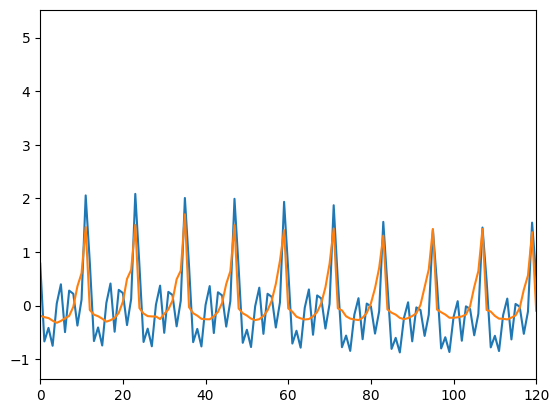

In [40]:
plt.plot(np.array(y_test))
plt.plot(y_pred.ravel())
plt.xlim([0,12*10])

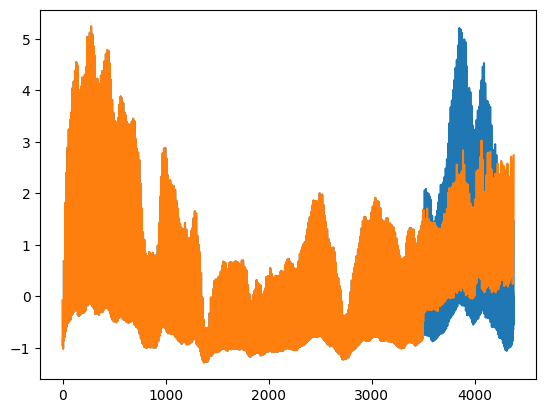

In [34]:
plt.plot(y)
plt.plot(np.concatenate((y_train.ravel(),y_pred.ravel())))
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Evaluate using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Evaluate using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Evaluate using Coefficient of Determination (R^2)
r2 = r2_score(y_test, y_pred)
print(f'Coefficient of Determination (R^2): {r2}')

Mean Squared Error (MSE): 0.8446980397944275
Root Mean Squared Error (RMSE): 0.9190745561674676
Mean Absolute Error (MAE): 0.7476686967448638
Coefficient of Determination (R^2): 0.3283555814071033


### LSTM - More variables

Epoch 1/50
88/88 [==============================] - 6s 14ms/step - loss: 0.6263 - val_loss: 0.1644
Epoch 2/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1767 - val_loss: 0.1009
Epoch 3/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1405 - val_loss: 0.0925
Epoch 4/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1317 - val_loss: 0.1015
Epoch 5/50
88/88 [==============================] - 0s 6ms/step - loss: 0.1263 - val_loss: 0.1267
Epoch 6/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1183 - val_loss: 0.1256
Epoch 7/50
88/88 [==============================] - 1s 6ms/step - loss: 0.1123 - val_loss: 0.1405
Epoch 8/50
28/28 [==============================] - 0s 3ms/step - loss: 0.3851
Test Loss: 0.3851167857646942
28/28 [==============================] - 1s 3ms/step


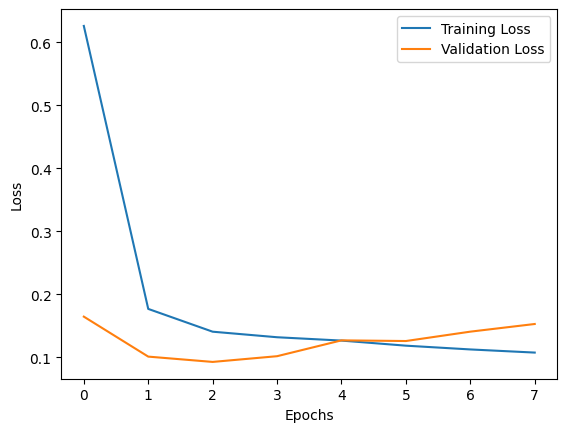

In [82]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load data
data = df_processed.copy()
# Assuming the data is already preprocessed and features are appropriately encoded

# Encode categorical variables
encoder = LabelEncoder()
data['Région'] = encoder.fit_transform(data['Région'])

# Convert Date to sinusoidal and cosinusoidal components
data['Date'] = pd.to_datetime(data['Date'])
data['Day_sin'] = np.sin(2 * np.pi * data['Date'].dt.day / 31)
data['Day_cos'] = np.cos(2 * np.pi * data['Date'].dt.day / 31)
data['Month_sin'] = np.sin(2 * np.pi * data['Date'].dt.month / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Date'].dt.month / 12)
data['Year_sin'] = np.sin(2 * np.pi * data['Date'].dt.year)
data['Year_cos'] = np.cos(2 * np.pi * data['Date'].dt.year)

# Drop the original Date column
data = data.drop(columns=['Date'])

# Normalize numerical features
scaler = StandardScaler()
var_names = ['Day_sin', 'Day_cos', 'Month_sin', 'Month_cos', 'Year_sin', 'Year_cos', 'Région', 'Temp', 'saison', 'week_day', 'is_holiday', 'is_bank_holiday', 'ce', 'Emissions']
data[var_names] = scaler.fit_transform(data[var_names])

# Split data into features and target
X = data[var_names[:-1]]
y = data[var_names[-1]]


# Reshape features for LSTM input [samples, timesteps, features]
X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict on test data
y_pred = model.predict(X_test)

# Optionally, you can inverse scale the predictions if necessary
# predictions = scaler.inverse_transform(predictions)

# Optionally, you can plot the training and validation loss to observe the training progress
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
np.linalg.norm(np.array(y_pred.ravel() - y_test))

18.367425172368147

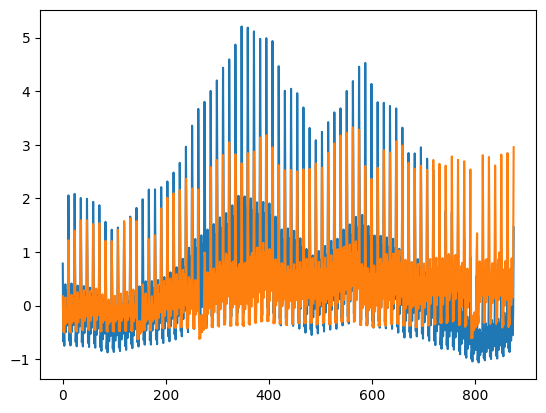

In [87]:
plt.plot(np.array(y_test))
plt.plot(y_pred.ravel())

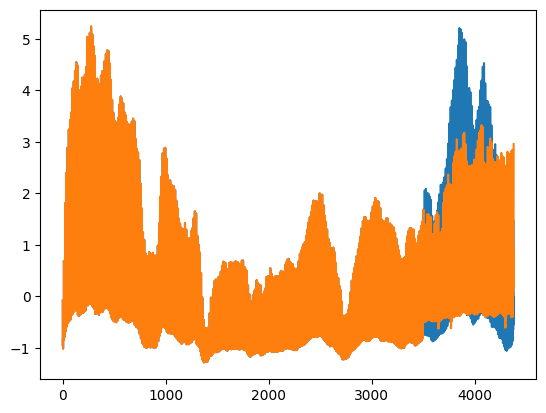

In [85]:
plt.plot(y)
plt.plot(np.concatenate((y_train.ravel(),y_pred.ravel())))
plt.show()

In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Evaluate using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Evaluate using Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Evaluate using Coefficient of Determination (R^2)
r2 = r2_score(y_test, y_pred)
print(f'Coefficient of Determination (R^2): {r2}')

Mean Squared Error (MSE): 0.38511678934080257
Root Mean Squared Error (RMSE): 0.6205777866962389
Mean Absolute Error (MAE): 0.44976368223564744
Coefficient of Determination (R^2): 0.6937822394732722
